In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/english-sentiment-on-steam-2021/english_sentiment_with_review.csv
/kaggle/input/steam-sentiment-schinese/sentiment_values_schinese.csv
/kaggle/input/russian-sentiment-analysis/final_combined_file.csv
/kaggle/input/steam-reviews-2021/steam_reviews.csv
/kaggle/input/steam-sentiment-eng/sentiment_reviews_eng.csv


In [2]:
file_path = '/kaggle/input/steam-reviews-2021/steam_reviews.csv'
eng_path = '/kaggle/input/english-sentiment-on-steam-2021/english_sentiment_with_review.csv'
sch_path = '/kaggle/input/steam-sentiment-schinese/sentiment_values_schinese.csv'
rus_path = '/kaggle/input/russian-sentiment-analysis/final_combined_file.csv'


In [3]:
import pandas as pd
import multiprocessing as mp
import os

# Load CSV files and add language column
def load_csv_initial(path, usecols, dtype, name, language):
    print(f"Loading {name} dataset from {path}")
    df = pd.read_csv(path, usecols=usecols, dtype=dtype)
    df['language'] = language  
    print(f"Finished loading {name} dataset with {len(df)} rows and added language: {language}")
    return df

# Load the datasets in parallel
def parallel_load():
    with mp.Pool(3) as pool:
        results = pool.starmap(load_csv_initial, [
            (file_path, ['review_id'], {'review_id': str}, 'original', None),
            (eng_path, ['review_id', 'review', 'sentiment'], {'review_id': str, 'review': str, 'sentiment': str}, 'English sentiments', 'English'),
            (sch_path, ['review_id', 'review', 'sentiment'], {'review_id': str, 'review': str, 'sentiment': str}, 'Simplified Chinese sentiments', 'Simplified Chinese'),
            (rus_path, ['review_id', 'review', 'sentiment'], {'review_id': str, 'review': str, 'sentiment': str}, 'Russian sentiments', 'Russian'),
        ])
    return results

# Load the data
review_ids, eng_sentiments, sch_sentiments, rus_sentiments = parallel_load()

print("Concatenating sentiment datasets")
sentiments = pd.concat([eng_sentiments, sch_sentiments, rus_sentiments]).drop_duplicates(subset='review_id')
print(f"Concatenated dataset has {len(sentiments)} rows")

print("Merging datasets")
filtered_reviews = pd.merge(
    review_ids[['review_id']],
    sentiments[['review_id', 'review', 'sentiment', 'language']],  # Include `language` from sentiments
    on='review_id',
    how='inner'
)
print(f"Filtered dataset has {len(filtered_reviews)} rows")

print("Displaying first few rows of the filtered dataset")
print(filtered_reviews.head())


Loading English sentiments dataset from /kaggle/input/english-sentiment-on-steam-2021/english_sentiment_with_review.csvLoading Simplified Chinese sentiments dataset from /kaggle/input/steam-sentiment-schinese/sentiment_values_schinese.csvLoading original dataset from /kaggle/input/steam-reviews-2021/steam_reviews.csv


Finished loading Simplified Chinese sentiments dataset with 3762149 rows and added language: Simplified Chinese
Loading Russian sentiments dataset from /kaggle/input/russian-sentiment-analysis/final_combined_file.csv
Finished loading Russian sentiments dataset with 2347907 rows and added language: Russian
Finished loading English sentiments dataset with 9632292 rows and added language: English
Finished loading original dataset with 21747371 rows and added language: None
Concatenating sentiment datasets
Concatenated dataset has 15643702 rows
Merging datasets
Filtered dataset has 15742340 rows
Displaying first few rows of the filtered dataset
  review_id                   

In [4]:
# Russian model is a 5 class classifier, that labeled some reviews as skippable or out of context, so we remove those rows
filtered_reviews = filtered_reviews[~filtered_reviews['sentiment'].isin(['skip', 'speech'])]
filtered_reviews

,review_id,review,sentiment,language
0,85185598,不玩此生遗憾，RPG游戏里的天花板，太吸引人了,positive,Simplified Chinese
1,85185250,拔DIAO无情打桩机--杰洛特!!!,positive,Simplified Chinese
2,85185111,巫师3NB,positive,Simplified Chinese
3,85184605,"One of the best RPG's of all time, worthy of a...",positive,English
4,85184287,大作,positive,Simplified Chinese
...,...,...,...,...
15742335,65645125,Holy balls,neutral,English
15742336,65645115,"A tripod thing bears down on you, it looks imm...",positive,English
15742337,65645100,Honestly this is the best vr game ever,positive,English
15742338,65645066,Smooth turning is not working right now.\nIt a...,positive,English


In [5]:
filtered_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15594238 entries, 0 to 15742339
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   review_id  object
 1   review     object
 2   sentiment  object
 3   language   object
dtypes: object(4)
memory usage: 594.9+ MB


In [6]:
def calculate_review_length(review, language):
    if pd.isna(review):
        return 0  
    if language == 'english':
        return len(re.findall(r'[a-zA-Z]', review))
    elif language == 'chinese':
        return len(re.findall(r'[\u4e00-\u9fff]', review))
    elif language == 'russian':
        return len(re.findall(r'[\u0400-\u04FF]', review))
    else:
        return len(review)

filtered_reviews['review_length'] = filtered_reviews.apply(
    lambda row: calculate_review_length(row['review'], row['language']), axis=1
)
filtered_reviews_l = filtered_reviews.drop(columns=['review'])
print(filtered_reviews_l.head())


  review_id sentiment            language  review_length
0  85185598  positive  Simplified Chinese             23
1  85185250  positive  Simplified Chinese             18
2  85185111  positive  Simplified Chinese              5
3  85184605  positive             English             59
4  85184287  positive  Simplified Chinese              2


# What is the distribution of sentiment across all reviews?

### Distribution in general

In [7]:
sentiment_distribution = filtered_reviews['sentiment'].value_counts()
sentiment_distribution

sentiment
positive    10052101
negative     2805061
neutral      2737068
Name: count, dtype: int64

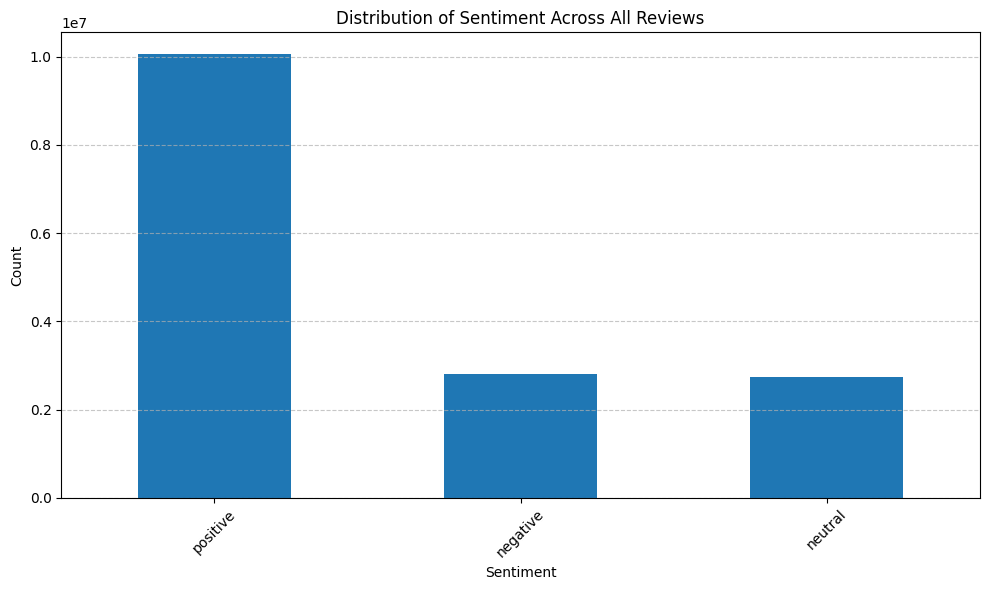

In [8]:
import matplotlib.pyplot as plt

# Plot 
plt.figure(figsize=(10, 6))
sentiment_distribution = filtered_reviews['sentiment'].value_counts()
sentiment_distribution.plot(kind='bar')
plt.title('Distribution of Sentiment Across All Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
sentiment_percentage = (sentiment_distribution / sentiment_distribution.sum()) * 100
sentiment_percentage

sentiment
positive    64.460387
negative    17.987813
neutral     17.551800
Name: count, dtype: float64

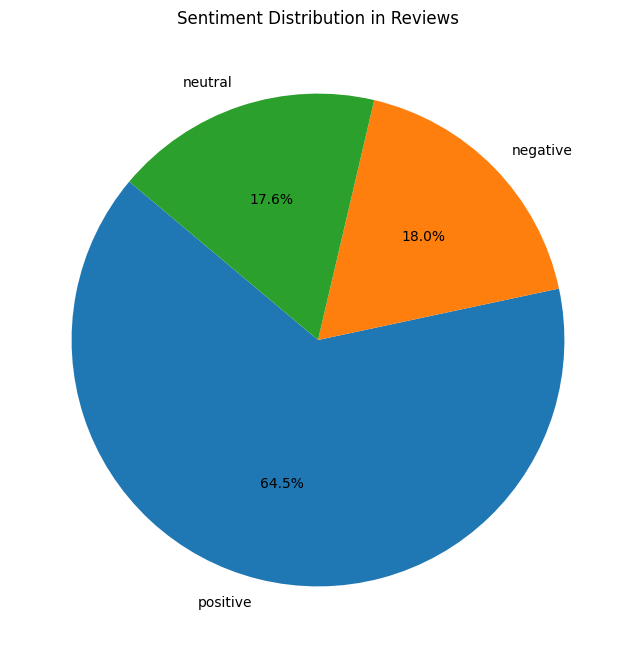

In [10]:
plt.figure(figsize=(8, 8))
sentiment_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Reviews')
plt.ylabel('')
plt.show()


### Distribution by Language

<Figure size 1200x600 with 0 Axes>

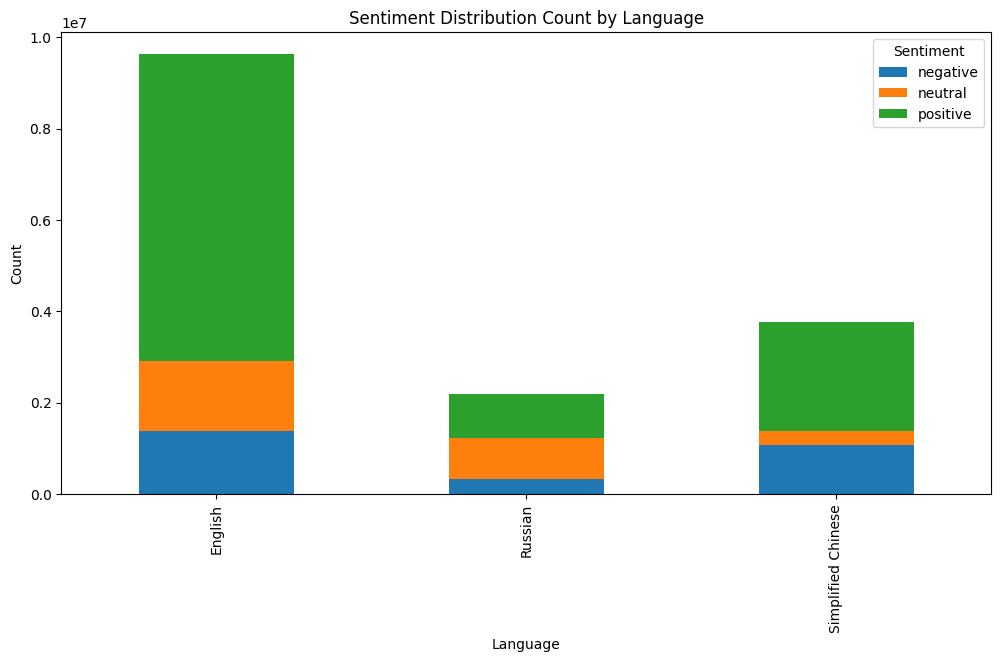

<Figure size 1200x600 with 0 Axes>

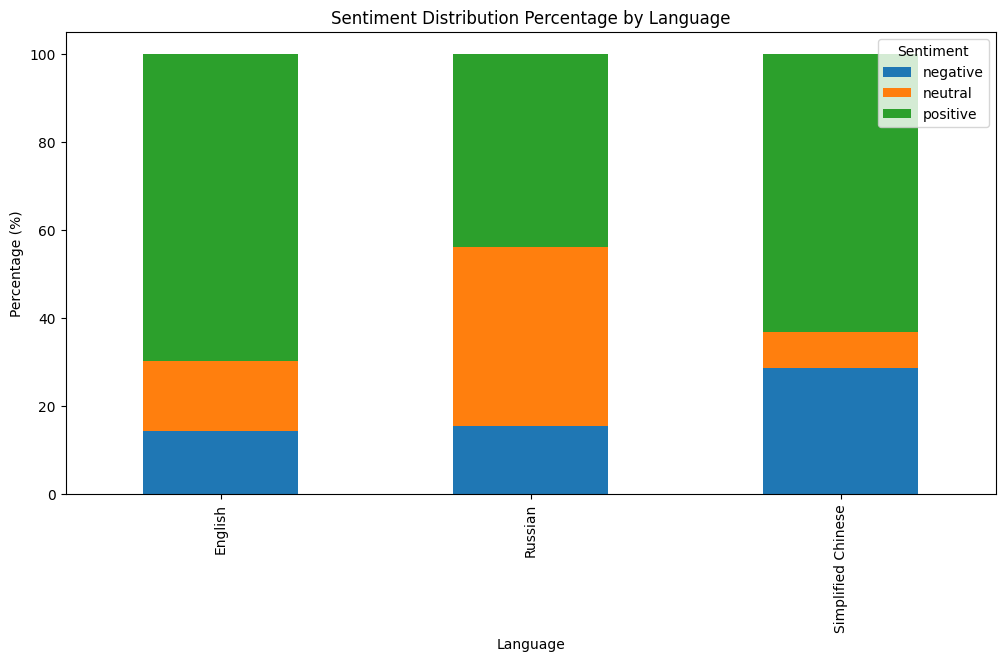

In [11]:
# by language
sentiment_counts = filtered_reviews.groupby(['language', 'sentiment']).size().unstack().fillna(0)
sentiment_percentage = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Count
plt.figure(figsize=(12, 6))
sentiment_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution Count by Language')
plt.xlabel('Language')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

# Percentage
plt.figure(figsize=(12, 6))
sentiment_percentage.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution Percentage by Language')
plt.xlabel('Language')
plt.ylabel('Percentage (%)')
plt.legend(title='Sentiment')
plt.show()


### Distribution over time

In [12]:
# general loading function
def load_csv(path, usecols, dtype, name):
    print(f"Loading {name} dataset from {path}")
    df = pd.read_csv(path, usecols=usecols, dtype=dtype)
    print(f"Finished loading {name} dataset with {len(df)}")
    return df

In [13]:
def load_timestamp_csv():
    with mp.Pool(1) as pool:
        timestamp_data = pool.starmap(load_csv, [
            (file_path, ['review_id', 'timestamp_created'], {'review_id': str, 'timestamp_created': str}, 'timestamp_created dataset')
        ])
    return timestamp_data[0]

timestamp_df = load_timestamp_csv()
print("Displaying first few rows of the timestamp_df dataset")
print(timestamp_df.head())
print("Merging timestamp_created dataset with filtered reviews")
merged_df = pd.merge(timestamp_df, filtered_reviews_l, on="review_id", how="inner")
merged_df['timestamp_created'] = pd.to_numeric(merged_df['timestamp_created'], errors='coerce')
merged_df['timestamp_created'] = pd.to_datetime(merged_df['timestamp_created'], unit = 's')


Loading timestamp_created dataset dataset from /kaggle/input/steam-reviews-2021/steam_reviews.csv
Finished loading timestamp_created dataset dataset with 21747371
Displaying first few rows of the timestamp_df dataset
  review_id timestamp_created
0  85185598        1611381629
1  85185250        1611381030
2  85185111        1611380800
3  85184605        1611379970
4  85184287        1611379427
Merging timestamp_created dataset with filtered reviews


In [14]:
merged_df.head()

,review_id,timestamp_created,sentiment,language,review_length
0,85185598,2021-01-23 06:00:29,positive,Simplified Chinese,23
1,85185250,2021-01-23 05:50:30,positive,Simplified Chinese,18
2,85185111,2021-01-23 05:46:40,positive,Simplified Chinese,5
3,85184605,2021-01-23 05:32:50,positive,English,59
4,85184287,2021-01-23 05:23:47,positive,Simplified Chinese,2


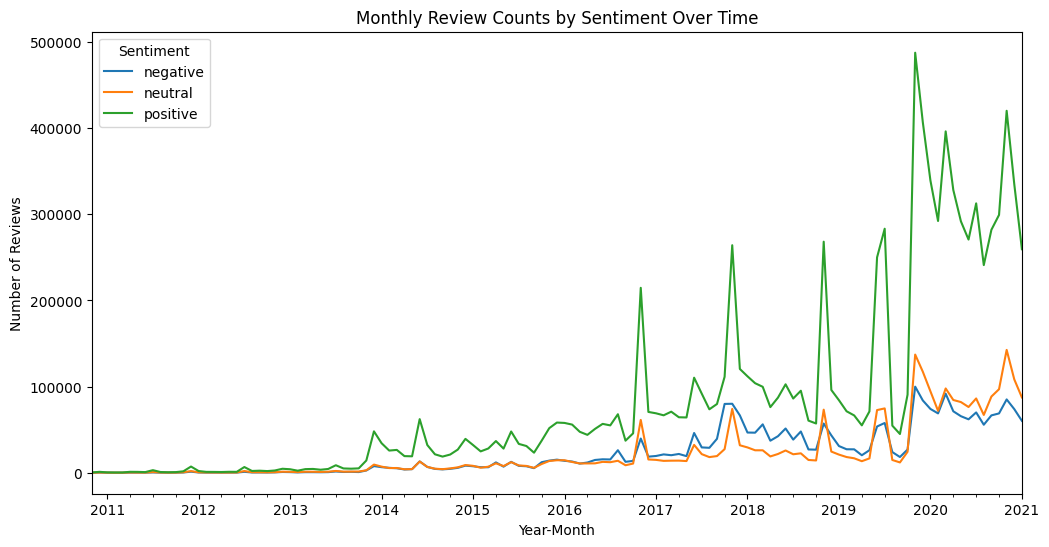

In [15]:
merged_df['year_month'] = merged_df['timestamp_created'].dt.to_period('M')
monthly_sentiment_counts = merged_df.groupby(['year_month', 'sentiment']).size().unstack(fill_value=0)

# Plot time series
plt.figure(figsize=(12, 6))
monthly_sentiment_counts.plot(kind='line', ax=plt.gca())
plt.title('Monthly Review Counts by Sentiment Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.show()

### By language

In [16]:
monthly_sentiment_counts = merged_df.groupby(['year_month', 'language', 'sentiment']).size().unstack(fill_value=0)

filtered_monthly_counts = {}
languages = monthly_sentiment_counts.index.get_level_values('language').unique()

for language in languages:
    language_data = monthly_sentiment_counts.xs(language, level='language')
    # Find the first month with any reviews
    first_month_with_reviews = language_data[(language_data > 0).any(axis=1)].index.min()
    # Filter data from the first month with reviews onward
    filtered_monthly_counts[language] = language_data[language_data.index >= first_month_with_reviews]
    
for language, data in filtered_monthly_counts.items():
    filtered_monthly_counts[language].index = filtered_monthly_counts[language].index.to_timestamp()


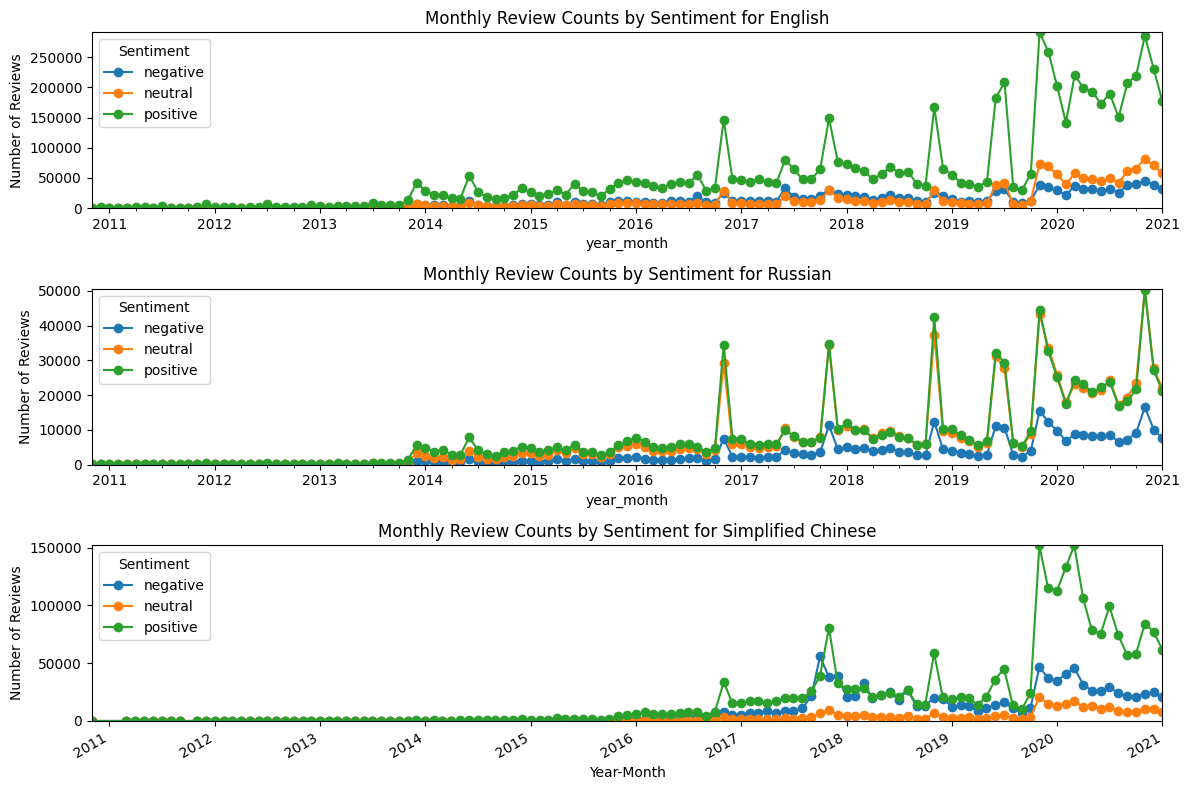

In [17]:
fig, axes = plt.subplots(len(languages), 1, figsize=(12, 8), sharex=False, sharey=False)

for i, language in enumerate(languages):
    ax = axes[i]
    filtered_data = filtered_monthly_counts[language]
    
    # Plot the data
    filtered_data.plot(kind='line', ax=ax, marker='o')
    
    # Set individual x-axis and y-axis limits for each language
    ax.set_xlim(filtered_data.index.min(), filtered_data.index.max())
    ax.set_ylim(0, filtered_data.max().max())  # Set y-axis from 0 to the max value for that language's data
    
    # Labeling
    ax.set_title(f'Monthly Review Counts by Sentiment for {language}')
    ax.set_ylabel('Number of Reviews')
    if i == len(languages) - 1:
        ax.set_xlabel('Year-Month')
    ax.legend(title='Sentiment')

plt.tight_layout()
plt.show()


### Distribution by Game

In [18]:
def load_app_name_csv():
    with mp.Pool(1) as pool:
        app_name_data = pool.starmap(load_csv, [
            (file_path, ['review_id', 'app_name'], {'review_id': str, 'app_name': str}, 'app_name dataset')
        ])
    return app_name_data[0]

app_name_df = load_app_name_csv()
print("Merging app_name dataset with filtered reviews")
final_reviews_game = pd.merge(filtered_reviews_l, app_name_df, on='review_id', how='inner')


Loading app_name dataset dataset from /kaggle/input/steam-reviews-2021/steam_reviews.csv
Finished loading app_name dataset dataset with 21747371
Merging app_name dataset with filtered reviews


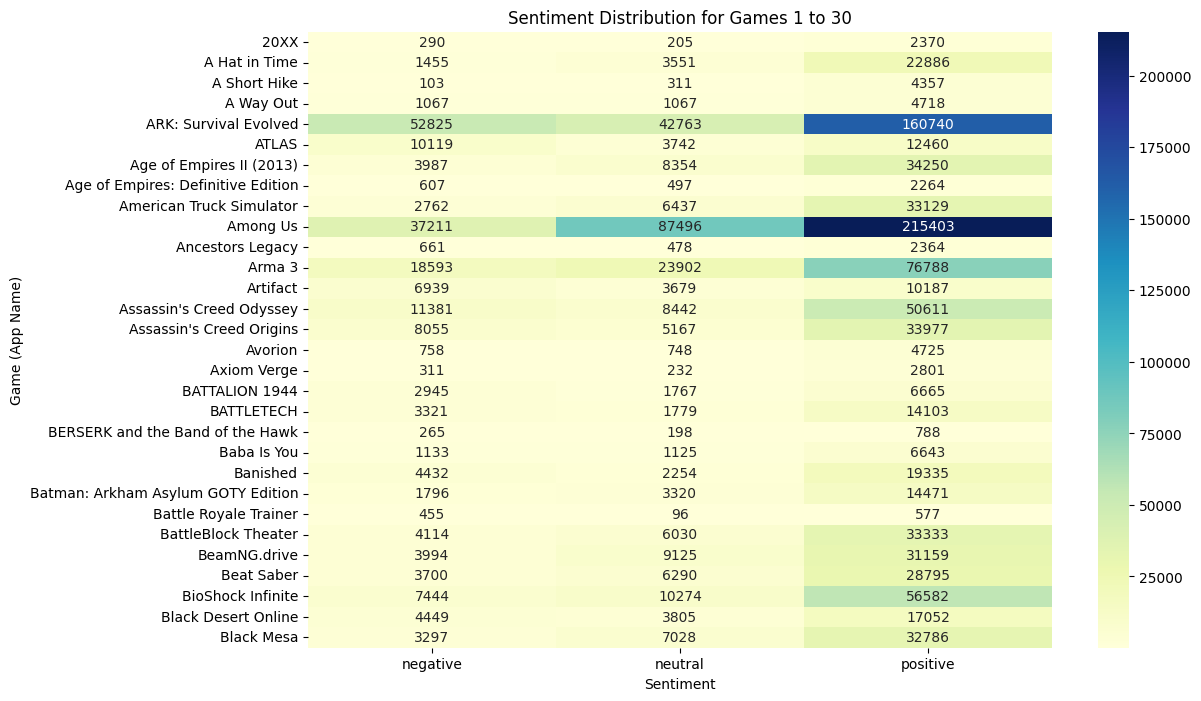

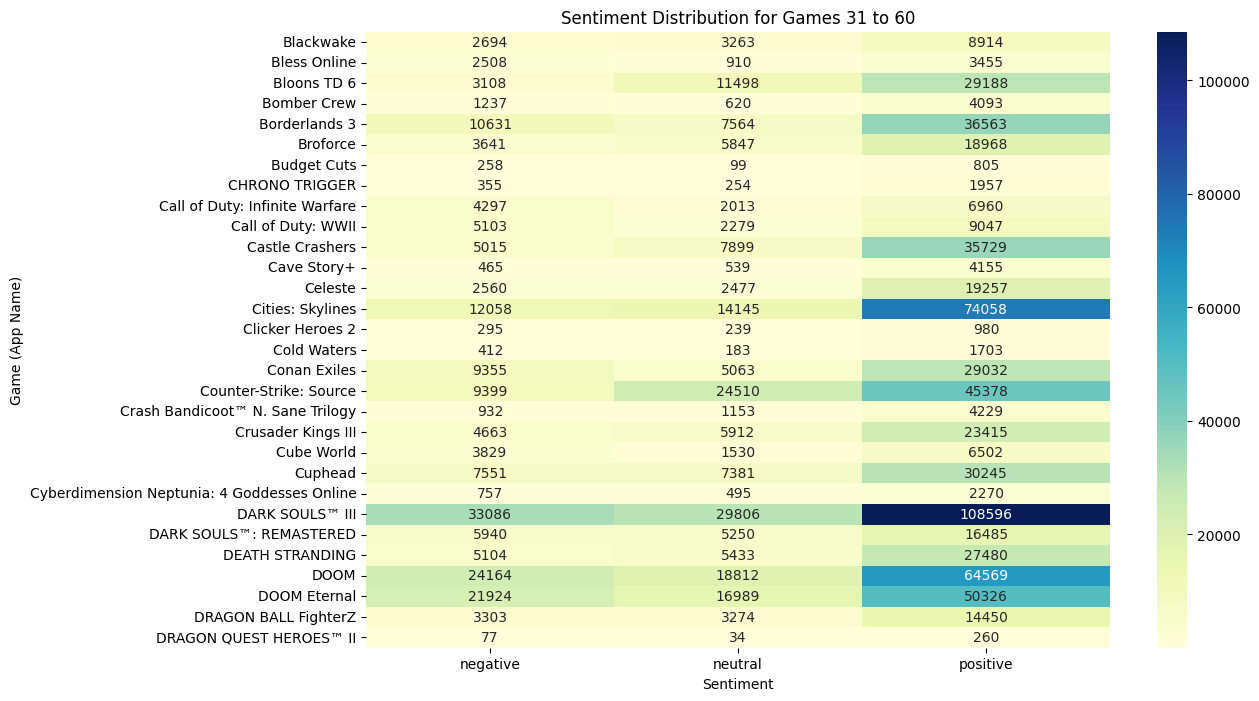

/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 40857 (\N{CJK UNIFIED IDEOGRAPH-9F99}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 23830 (\N{CJK UNIFIED IDEOGRAPH-5D16}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 40857 (\N{CJK UNIFIED IDEOGRAPH-9F99}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23830 (\N{CJK UNIFIED IDEOGRAPH-5D16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


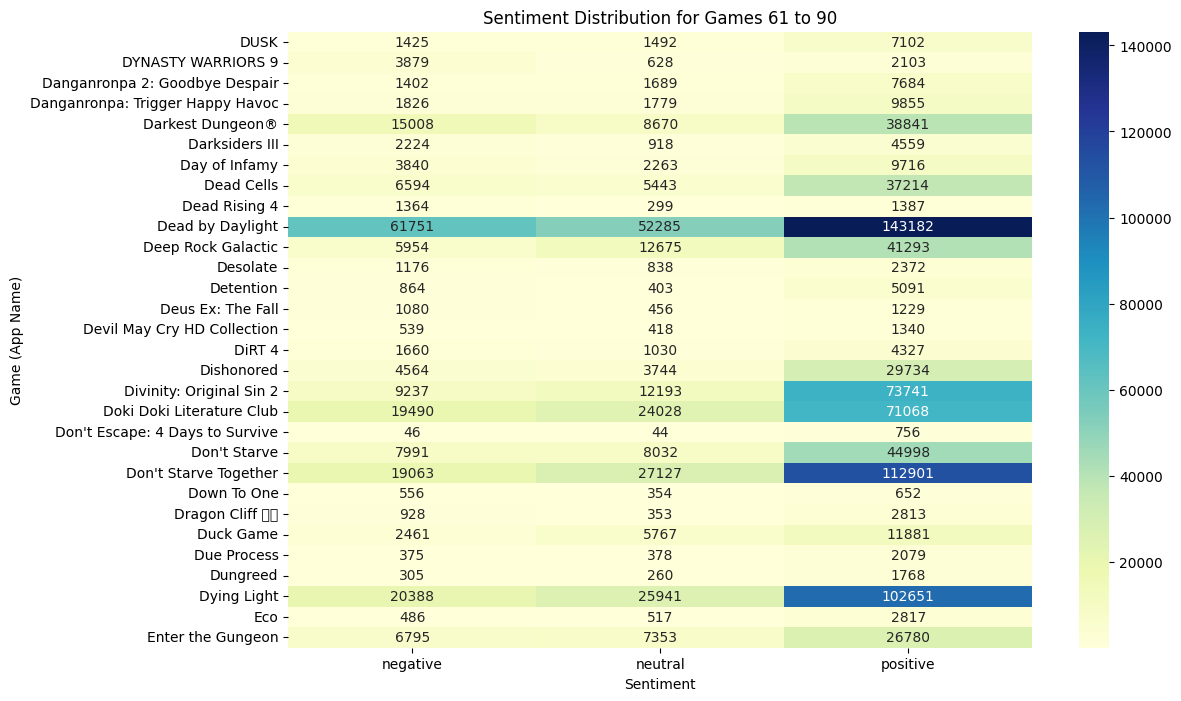

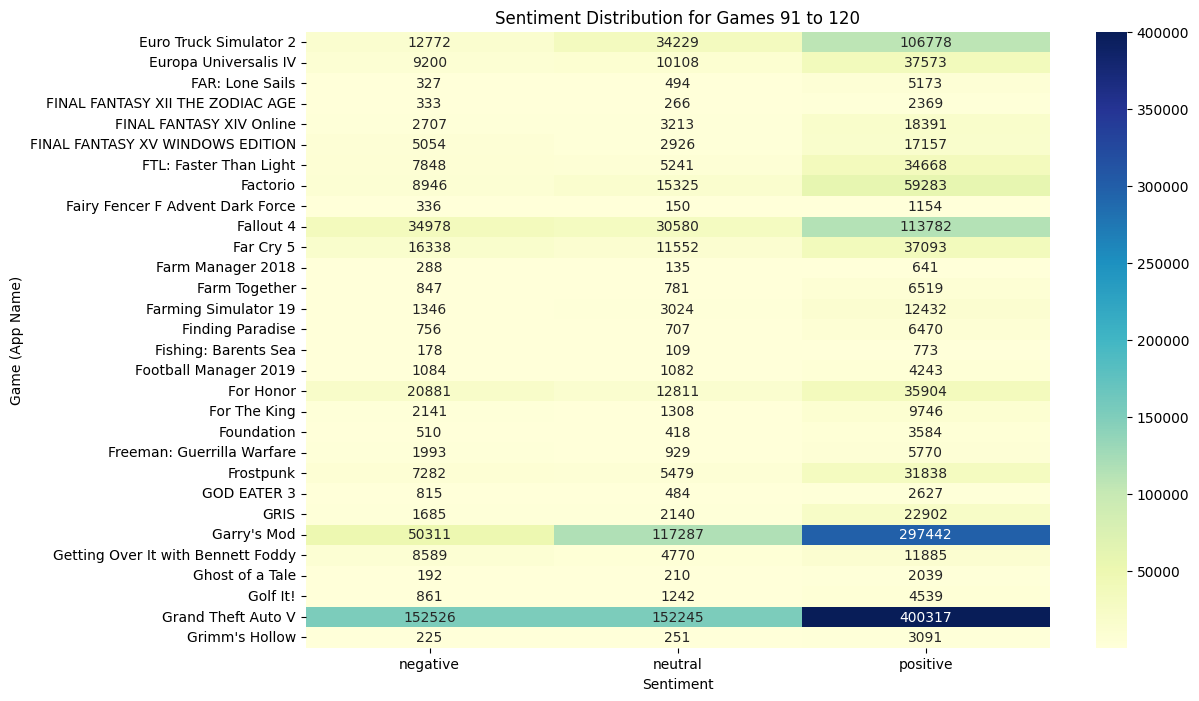

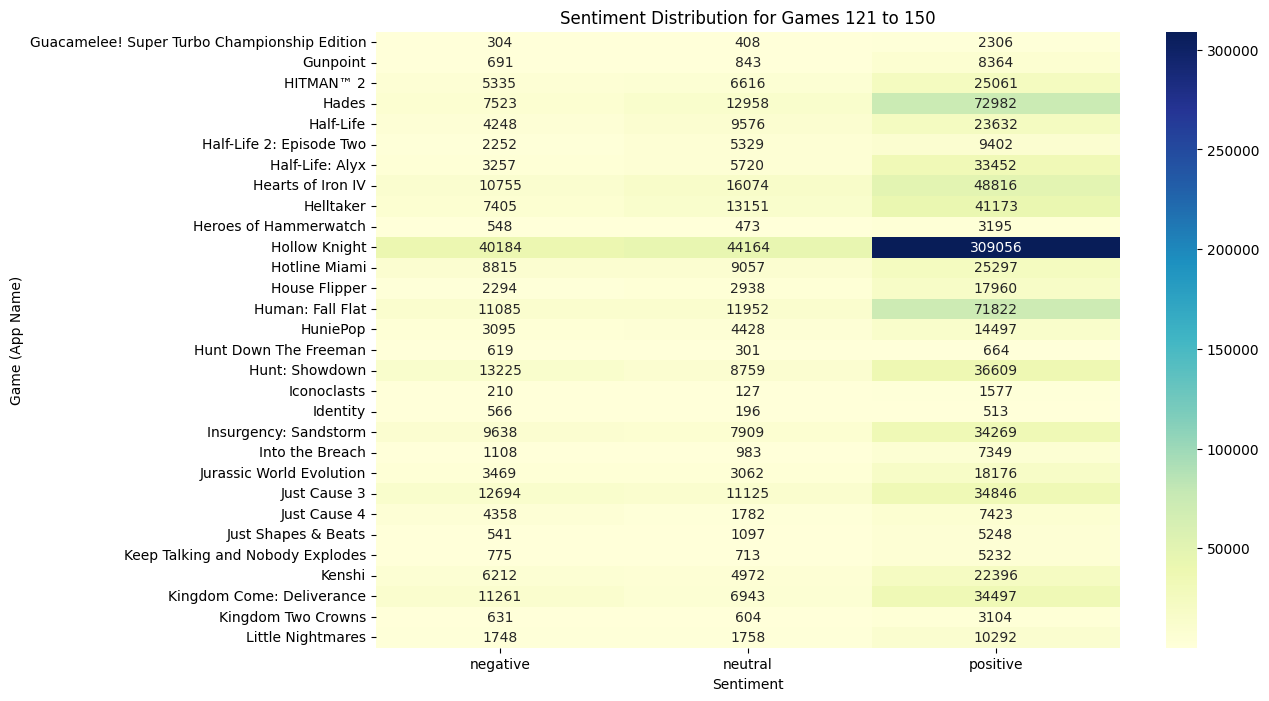

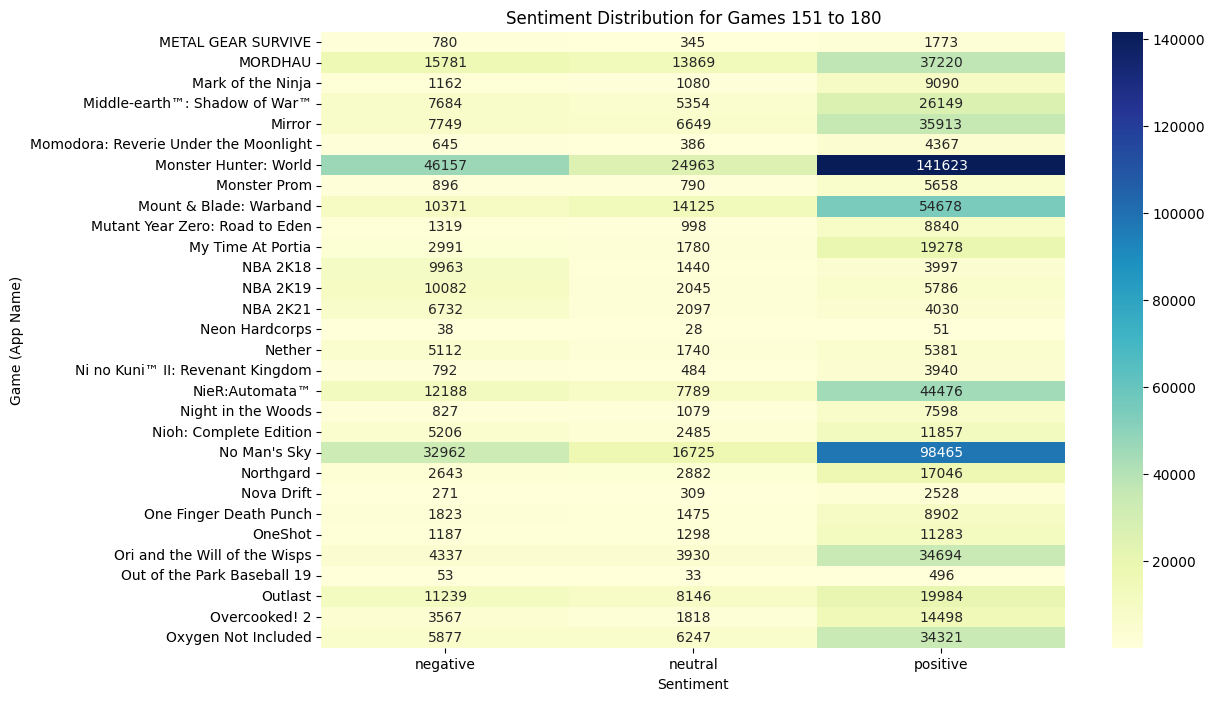

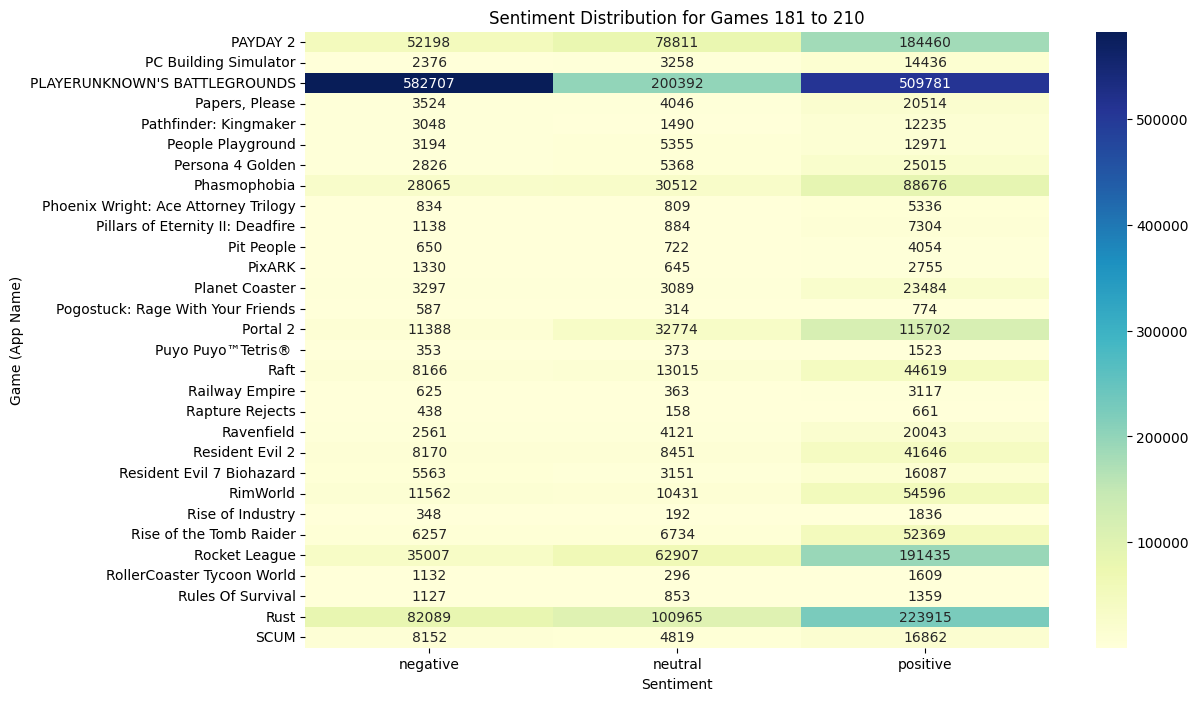

/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 65290 (\N{FULLWIDTH ASTERISK}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65290 (\N{FULLWIDTH ASTERISK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


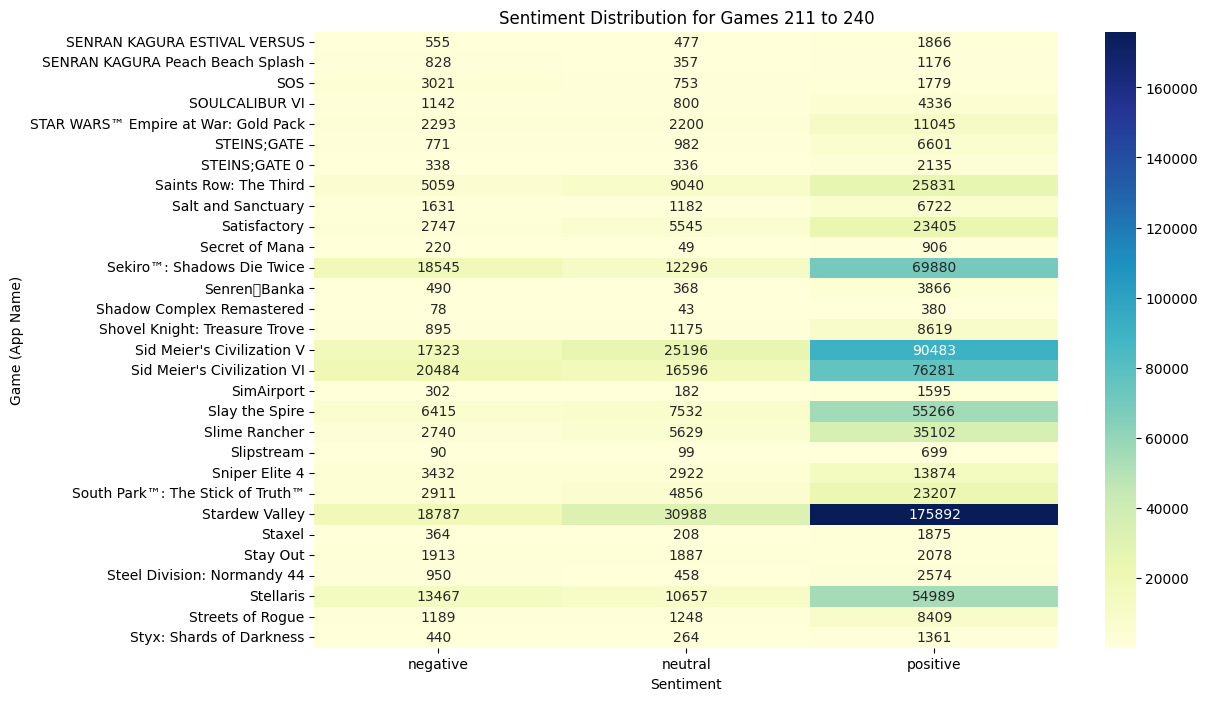

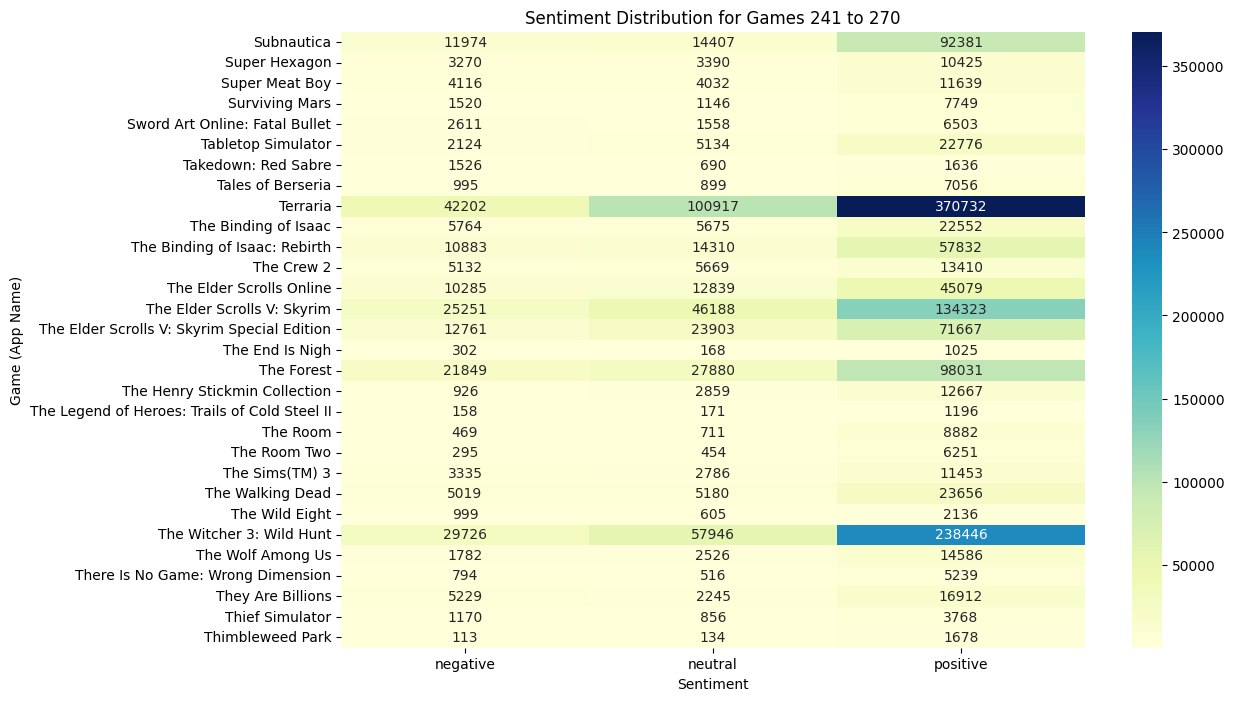

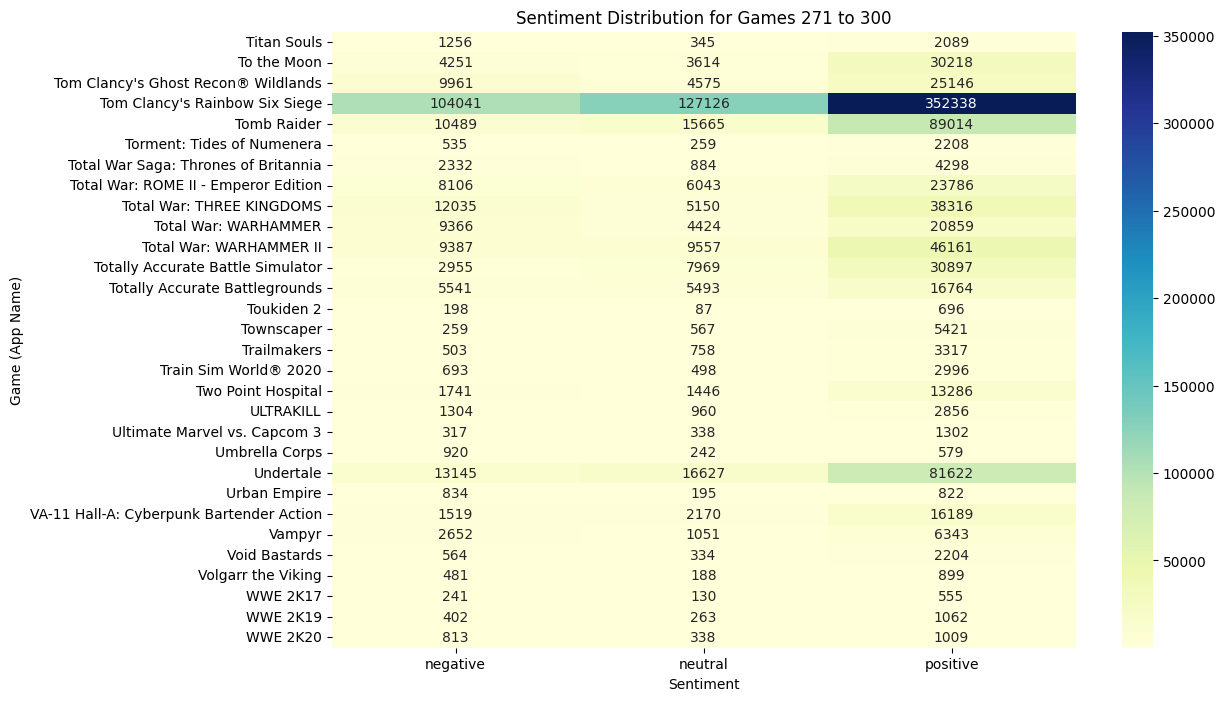

/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 32676 (\N{CJK UNIFIED IDEOGRAPH-7FA4}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 20256 (\N{CJK UNIFIED IDEOGRAPH-4F20}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from current font.
  fig.canvas.

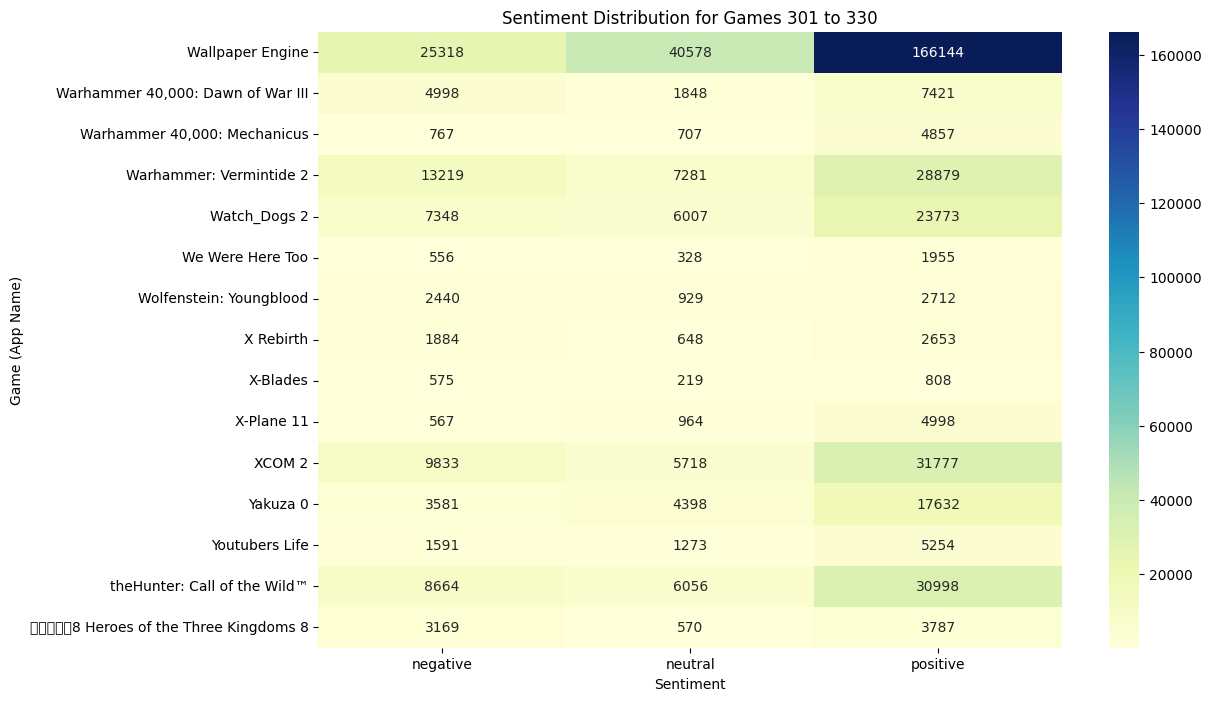

In [19]:
import seaborn as sns
import math
import matplotlib.pyplot as plt

games_per_section = 30  
num_sections = math.ceil(final_reviews_game['app_name'].nunique() / games_per_section)

sentiment_counts = final_reviews_game.pivot_table(
    index='app_name',
    columns='sentiment',
    aggfunc='size',
    fill_value=0
)

all_games = sentiment_counts.index.tolist()

# Plot each section
for i in range(num_sections):
    section_games = all_games[i * games_per_section:(i + 1) * games_per_section]
    section_data = sentiment_counts.loc[section_games]

    plt.figure(figsize=(12, 8))
    sns.heatmap(section_data, cmap="YlGnBu", annot=True, fmt="d")
    plt.title(f"Sentiment Distribution for Games {i * games_per_section + 1} to {(i + 1) * games_per_section}")
    plt.xlabel("Sentiment")
    plt.ylabel("Game (App Name)")
    plt.show()



The warning is plt that can't render chinese character, no need to address this issue

### Relationship between Sentiment and Review Lenght

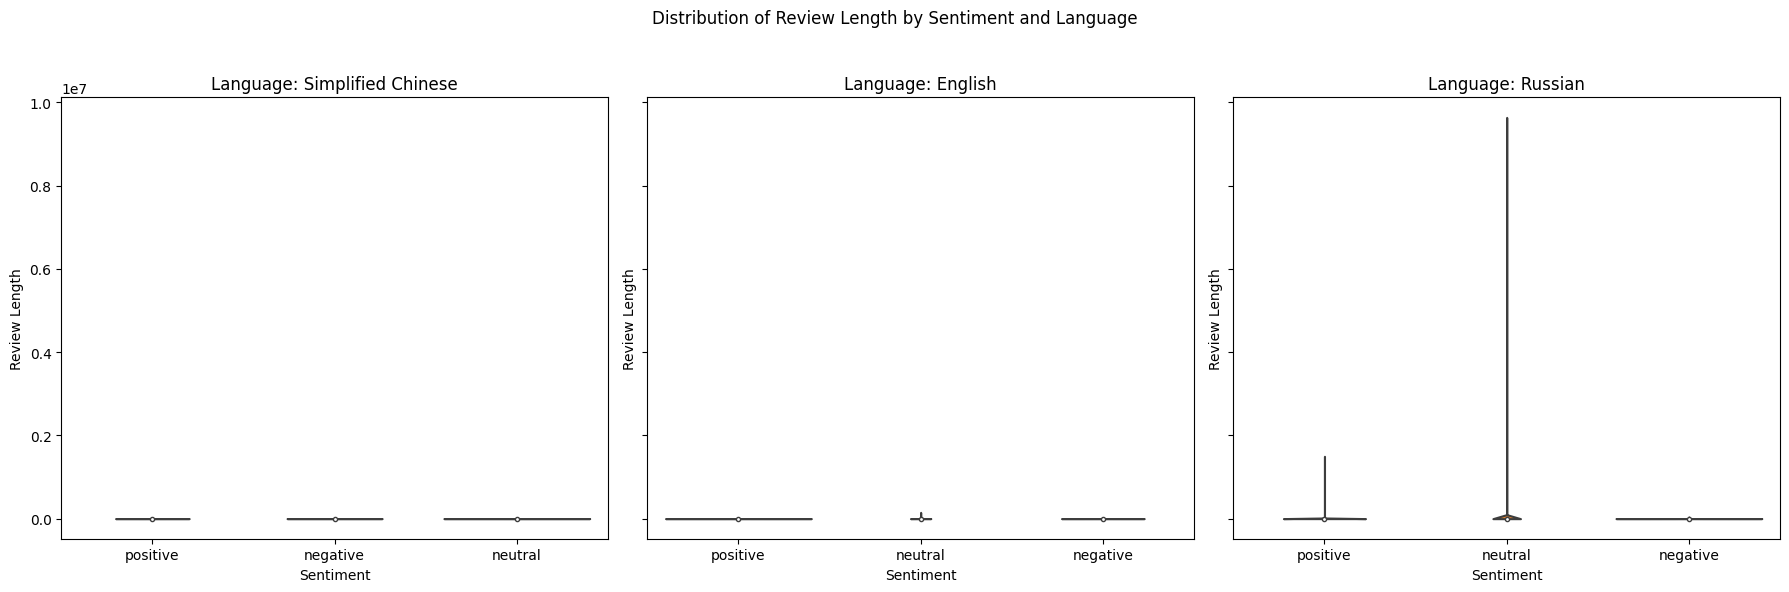

In [20]:
languages = filtered_reviews_l['language'].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Distribution of Review Length by Sentiment and Language')

for i, language in enumerate(languages):
    sns.violinplot(x='sentiment', y='review_length', data=filtered_reviews_l[filtered_reviews_l['language'] == language], ax=axes[i])
    axes[i].set_title(f'Language: {language}')
    axes[i].set_xlabel('Sentiment')
    axes[i].set_ylabel('Review Length')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [21]:
# summary statistics
summary_stats = filtered_reviews_l.groupby(['language', 'sentiment'])['review_length'].describe()
print("Summary Statistics for Review Length by Language and Sentiment:")
summary_stats

Summary Statistics for Review Length by Language and Sentiment:


count        mean           std  min   25%  \
language           sentiment                                                   
English            negative   1385992.0  316.657120    672.454064  1.0  41.0   
                   neutral    1537228.0   44.214646    247.613596  0.0   6.0   
                   positive   6709072.0  234.375378    522.200537  1.0  23.0   
Russian            negative    339356.0  162.553109    435.271386  1.0  17.0   
                   neutral     897567.0  219.157537  10199.800576  0.0   9.0   
                   positive    962882.0  171.180141   1700.928913  1.0  21.0   
Simplified Chinese negative   1079713.0   50.644655    130.005162  1.0  10.0   
                   neutral     302273.0   47.691028    209.527166  1.0   6.0   
                   positive   2380147.0   54.349248    190.091068  0.0   5.0   

                                50%    75%        max  
language           sentiment                           
English            negative   104.0  292.0     8218.0  
                   neutral     15.0   36.0   150000.0  
                   positive    74.0  219.0     8000.0  
Russian            negative    43.0  128.0    40049.0  
                   neutral     31.0  108.0  9639004.0  
                   positive    53.0  144.0  1496880.0  
Simplified Chinese negative    22.0   48.0     8000.0  
                   neutral     14.0   31.0     8000.0  
                   positive    14.0   37.0     8000.0

Some outliers make the results unreliable

In [22]:
top_100_outliers = filtered_reviews_l.sort_values(by='review_length', ascending=False).head(100)
print("Top 100 Outliers by Review Length:")
print(top_100_outliers[['review_id', 'language', 'sentiment', 'review_length']])


Top 100 Outliers by Review Length:
         review_id language sentiment  review_length
14896571  18042721  Russian   neutral        9639004
5476892   33634014  Russian  positive        1496880
1467949   29208693  Russian  positive         447528
13170641  26673926  Russian  positive         300000
932774    31314218  Russian  positive         262167
...            ...      ...       ...            ...
6095975   85051334  English   neutral           8000
13130904  46309816  Russian   neutral           8000
5120239   84879873  English   neutral           8000
6357146   40797249  English   neutral           8000
12157707  28913263  English   neutral           8000

[100 rows x 4 columns]


In [23]:
filtered_reviews_l = filtered_reviews_l[filtered_reviews_l['review_length'] <= 8000]

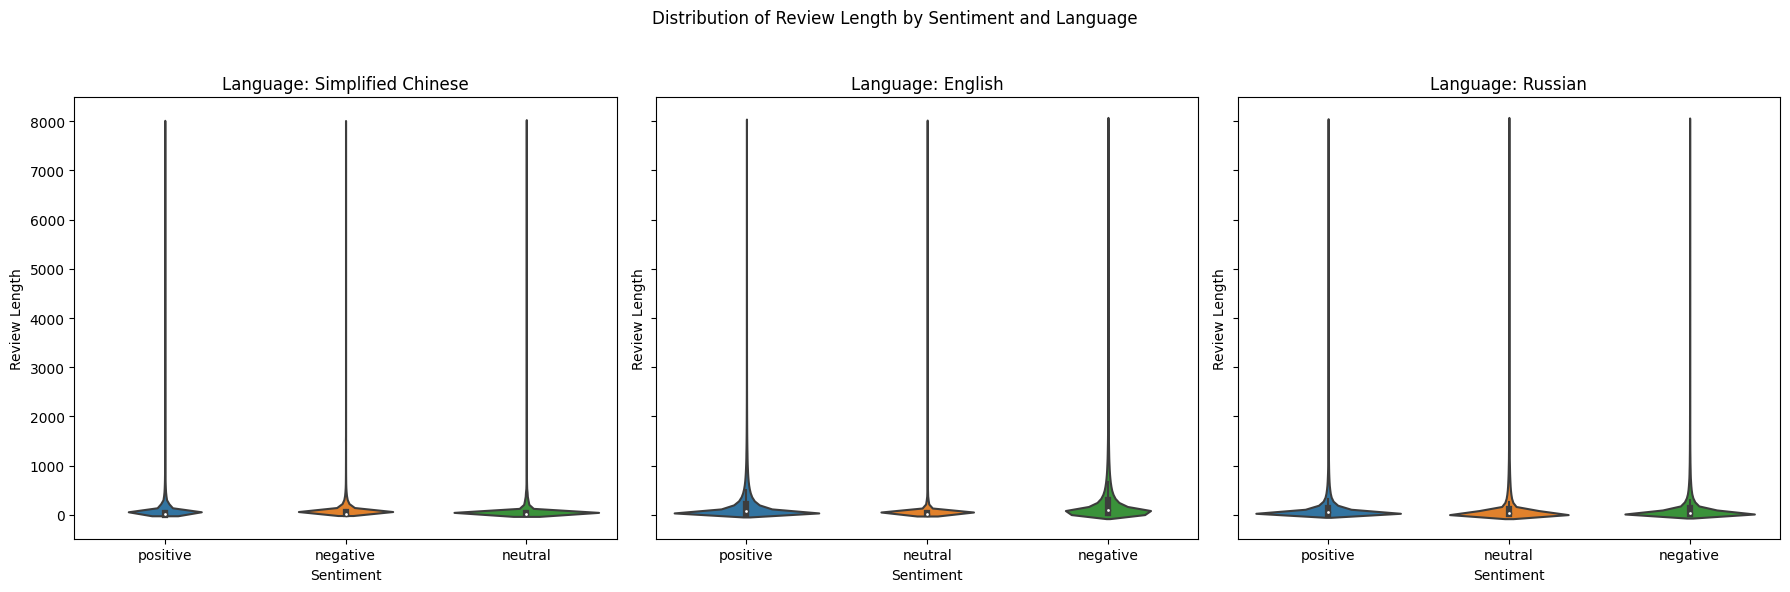

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Distribution of Review Length by Sentiment and Language')

for i, language in enumerate(languages):
    sns.violinplot(x='sentiment', y='review_length', data=filtered_reviews_l[filtered_reviews_l['language'] == language], ax=axes[i])
    axes[i].set_title(f'Language: {language}')
    axes[i].set_xlabel('Sentiment')
    axes[i].set_ylabel('Review Length')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [25]:
summary_stats = filtered_reviews_l.groupby(['language', 'sentiment'])['review_length'].describe()
print("Summary Statistics for Review Length by Language and Sentiment:")
summary_stats

Summary Statistics for Review Length by Language and Sentiment:


count        mean         std  min   25%  \
language           sentiment                                                 
English            negative   1385991.0  316.651419  672.420813  1.0  41.0   
                   neutral    1537227.0   44.117097  216.065722  0.0   6.0   
                   positive   6709072.0  234.375378  522.200537  1.0  23.0   
Russian            negative    339355.0  162.435573  429.853015  1.0  17.0   
                   neutral     897564.0  207.835075  611.490754  0.0   9.0   
                   positive    962877.0  168.422033  413.340154  1.0  21.0   
Simplified Chinese negative   1079713.0   50.644655  130.005162  1.0  10.0   
                   neutral     302273.0   47.691028  209.527166  1.0   6.0   
                   positive   2380147.0   54.349248  190.091068  0.0   5.0   

                                50%    75%     max  
language           sentiment                        
English            negative   104.0  292.0  8000.0  
                   neutral     15.0   36.0  8000.0  
                   positive    74.0  219.0  8000.0  
Russian            negative    43.0  128.0  8000.0  
                   neutral     31.0  108.0  8000.0  
                   positive    53.0  144.0  8000.0  
Simplified Chinese negative    22.0   48.0  8000.0  
                   neutral     14.0   31.0  8000.0  
                   positive    14.0   37.0  8000.0

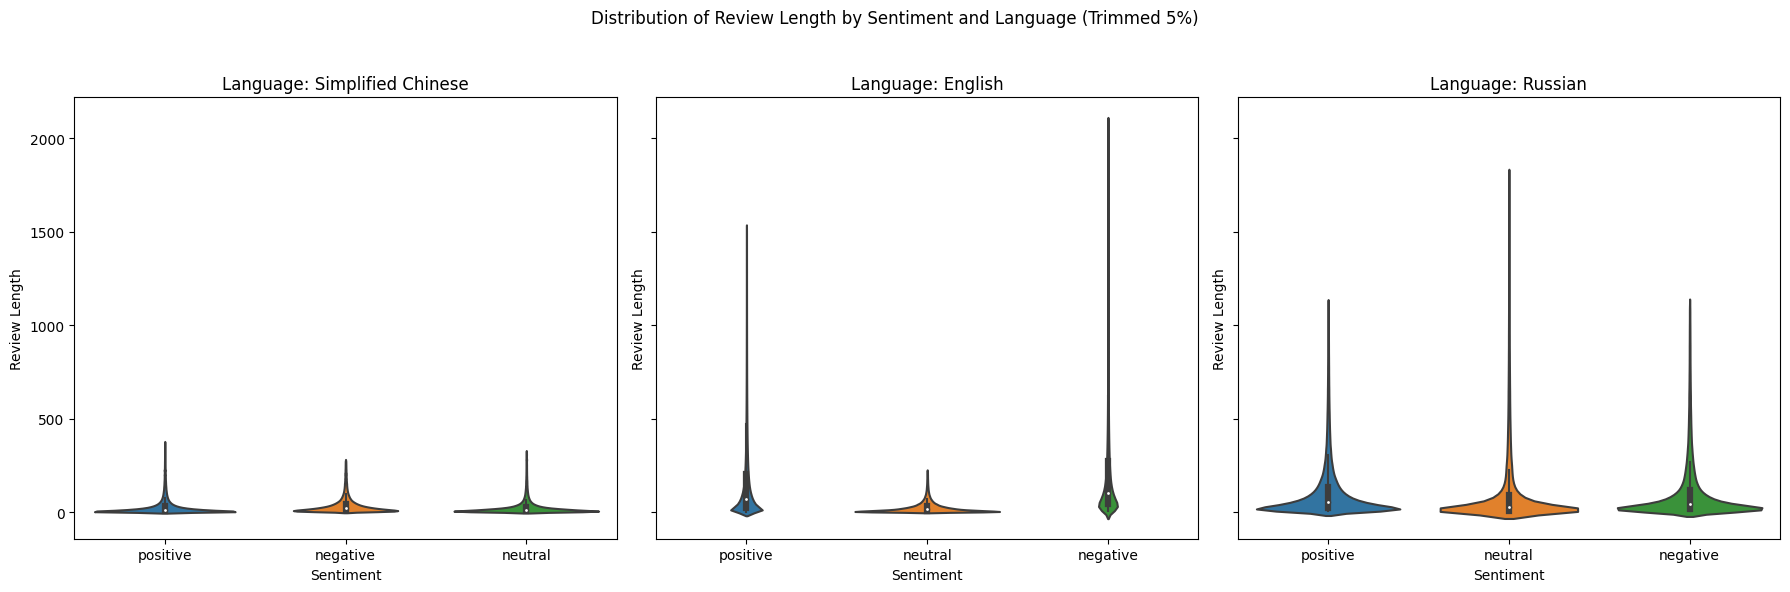

In [26]:
filtered_data = pd.DataFrame()
# Let's try to remove 2.5% on each side
for language in languages:
    language_data = filtered_reviews_l[filtered_reviews_l['language'] == language]
    for sentiment in language_data['sentiment'].unique():
        sentiment_data = language_data[language_data['sentiment'] == sentiment]
        lower_bound = sentiment_data['review_length'].quantile(0.025)
        upper_bound = sentiment_data['review_length'].quantile(0.975)
        filtered_sentiment_data = sentiment_data[(sentiment_data['review_length'] >= lower_bound) & 
                                                 (sentiment_data['review_length'] <= upper_bound)]
        filtered_data = pd.concat([filtered_data, filtered_sentiment_data])

# Plot the filtered data
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Distribution of Review Length by Sentiment and Language (Trimmed 5%)')

for i, language in enumerate(languages):
    sns.violinplot(x='sentiment', y='review_length', data=filtered_data[filtered_data['language'] == language], ax=axes[i])
    axes[i].set_title(f'Language: {language}')
    axes[i].set_xlabel('Sentiment')
    axes[i].set_ylabel('Review Length')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Users writing in English tend to produce longer reviews overall, likely because review length is measured in character count, and English words generally require more characters than Chinese or Russian. 

Interestingly, English users tend to use more words when describing positive experiences, suggesting they may provide more detailed feedback when satisfied. In contrast, Chinese and Russian users typically keep positive reviews brief, while negative reviews are sometimes longer. This pattern could indicate that Chinese and Russian users prefer to elaborate more when expressing dissatisfaction or highlighting issues.



In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping 
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
filtered_reviews_l['sentiment_score'] = filtered_reviews_l['sentiment'].map(sentiment_mapping)

# Correlation between review length and sentiment score by language
correlation_by_language = filtered_reviews_l.groupby('language')[['review_length', 'sentiment_score']].corr().unstack().iloc[:,1]
print("Correlation between review length and sentiment score by language:")
print(correlation_by_language)

Correlation between review length and sentiment score by language:
language
English              -0.004222
Russian              -0.009315
Simplified Chinese    0.010218
Name: (review_length, sentiment_score), dtype: float64


These correlation values are all very close to zero, indicating that review length is not strongly related to sentiment score in any of the three languages.

/tmp/ipykernel_17/1085173327.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_sentiment_counts = filtered_reviews_l.groupby(['language', 'length_category', 'sentiment']).size().unstack(fill_value=0)


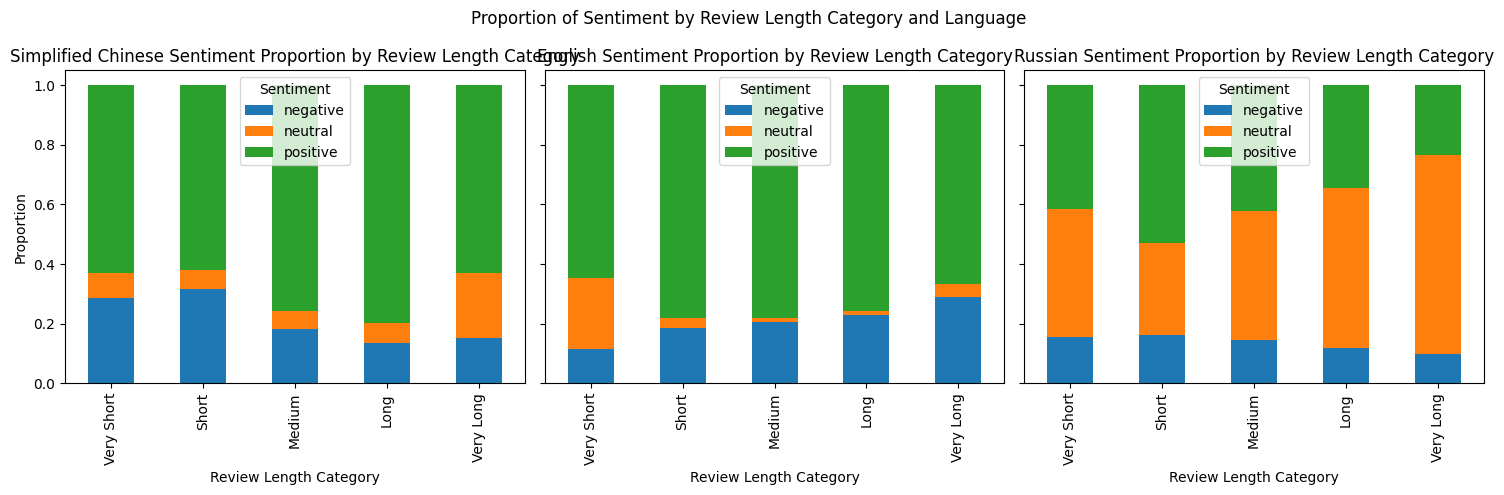

In [28]:
# For simplification we map the review lenght into category
bins = [0, 100, 500, 1000, 5000, float("inf")]  # boundaries 
labels = ['Very Short', 'Short', 'Medium', 'Long', 'Very Long']  # Labels 
filtered_reviews_l['length_category'] = pd.cut(filtered_reviews_l['review_length'], bins=bins, labels=labels)

filtered_reviews_l['sentiment_score'] = filtered_reviews_l['sentiment'].map(sentiment_mapping)

length_sentiment_counts = filtered_reviews_l.groupby(['language', 'length_category', 'sentiment']).size().unstack(fill_value=0)
length_sentiment_proportions = length_sentiment_counts.div(length_sentiment_counts.sum(axis=1), axis=0)

# Plot 
fig, axes = plt.subplots(1, len(languages), figsize=(15, 5), sharey=True)

for i, language in enumerate(languages):
    length_sentiment_proportions.loc[language].plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'{language} Sentiment Proportion by Review Length Category')
    axes[i].set_xlabel('Review Length Category')
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='Sentiment')

plt.suptitle('Proportion of Sentiment by Review Length Category and Language')
plt.tight_layout()
plt.show()


# Does the sentiment analysis align with whether the application is recommended or not? Explain any insights from this comparison.

In [29]:
def load_recommended_csv():
    with mp.Pool(1) as pool:
        recommended_data = pool.starmap(load_csv, [
            (file_path, ['review_id', 'recommended'], {'review_id': str, 'recommended': bool}, 'recommended dataset')
        ])
    return recommended_data[0]

recommended_df = load_recommended_csv()
print("Merging recommended dataset with filtered reviews")
final_reviews_recommended = pd.merge(filtered_reviews_l, recommended_df, on='review_id', how='inner')


Loading recommended dataset dataset from /kaggle/input/steam-reviews-2021/steam_reviews.csv
Finished loading recommended dataset dataset with 21747371
Merging recommended dataset with filtered reviews


In [30]:
final_reviews_recommended.head()


,review_id,sentiment,language,review_length,sentiment_score,length_category,recommended
0,85185598,positive,Simplified Chinese,23,1.0,Very Short,True
1,85185250,positive,Simplified Chinese,18,1.0,Very Short,True
2,85185111,positive,Simplified Chinese,5,1.0,Very Short,True
3,85184605,positive,English,59,1.0,Very Short,True
4,85184287,positive,Simplified Chinese,2,1.0,Very Short,True


In [31]:
sentiment_recommendation_counts = final_reviews_recommended.pivot_table(
    index='sentiment',
    columns='recommended',
    aggfunc='size',
    fill_value=0
)

print(sentiment_recommendation_counts)

recommended    False    True 
sentiment                    
negative     1314773  1510378
neutral       334118  2425028
positive      510724  9695900


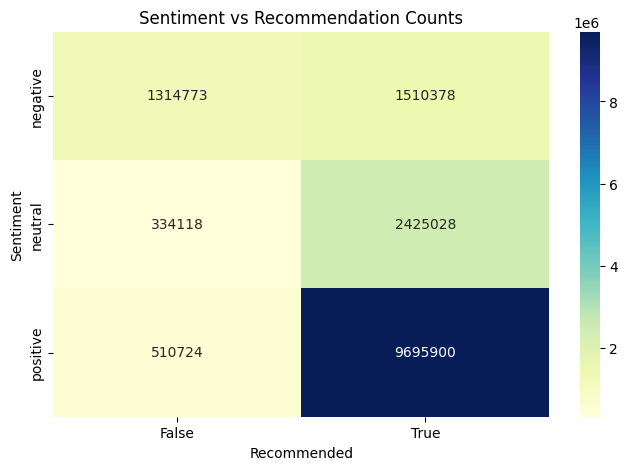

In [32]:
plt.figure(figsize=(8, 5))
sns.heatmap(sentiment_recommendation_counts, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Sentiment vs Recommendation Counts")
plt.xlabel("Recommended")
plt.ylabel("Sentiment")
plt.show()

In [33]:
sentiment_recommendation_percent = sentiment_recommendation_counts.div(sentiment_recommendation_counts.sum(axis=1), axis=0) * 100

print(sentiment_recommendation_percent)

recommended      False      True 
sentiment                        
negative     46.538150  53.461850
neutral      12.109472  87.890528
positive      5.003848  94.996152


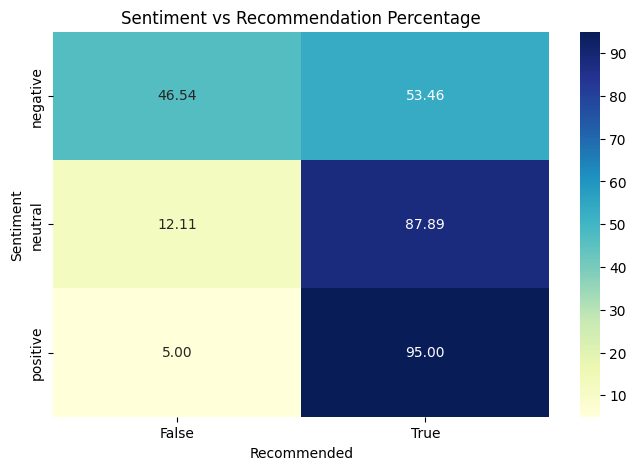

In [34]:
plt.figure(figsize=(8, 5))
sns.heatmap(sentiment_recommendation_percent, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Sentiment vs Recommendation Percentage")
plt.xlabel("Recommended")
plt.ylabel("Sentiment")
plt.show()


this heatmap provides a clear view of how sentiment correlates with recommendation, highlighting that positive sentiment is a strong indicator of recommendation, while negative sentiment does not necessarily equate to non-recommendation.

/tmp/ipykernel_17/2167001254.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_counts = final_reviews_recommended.groupby(['recommended', 'length_category', 'sentiment']).size().unstack(fill_value=0)


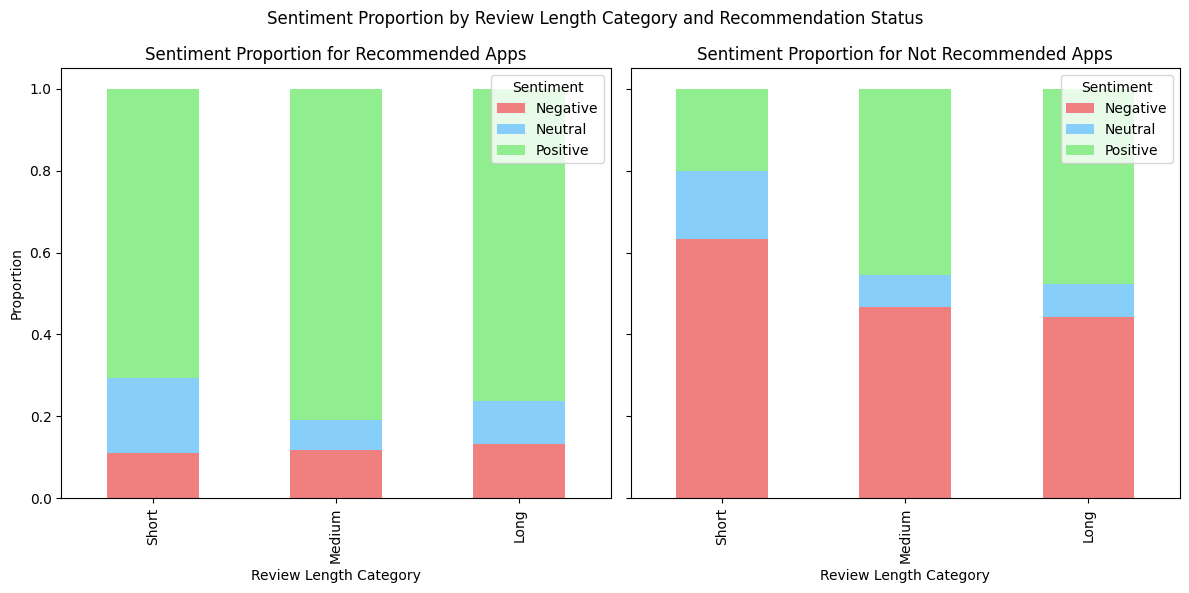

In [35]:
bins = [0, 500, 1000, float("inf")]
labels = ['Short', 'Medium', 'Long']
final_reviews_recommended['length_category'] = pd.cut(final_reviews_recommended['review_length'], bins=bins, labels=labels)

sentiment_counts = final_reviews_recommended.groupby(['recommended', 'length_category', 'sentiment']).size().unstack(fill_value=0)
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

recommended_proportions = sentiment_proportions.loc[True]
not_recommended_proportions = sentiment_proportions.loc[False]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
# Plot for 'True' 
recommended_proportions.plot(kind='bar', stacked=True, ax=axes[0], color=['lightcoral', 'lightskyblue', 'lightgreen'])
axes[0].set_title("Sentiment Proportion for Recommended Apps")
axes[0].set_xlabel("Review Length Category")
axes[0].set_ylabel("Proportion")
axes[0].legend(title="Sentiment", labels=['Negative', 'Neutral', 'Positive'])

# Plot for 'False' 
not_recommended_proportions.plot(kind='bar', stacked=True, ax=axes[1], color=['lightcoral', 'lightskyblue', 'lightgreen'])
axes[1].set_title("Sentiment Proportion for Not Recommended Apps")
axes[1].set_xlabel("Review Length Category")
axes[1].legend(title="Sentiment", labels=['Negative', 'Neutral', 'Positive'])

plt.suptitle("Sentiment Proportion by Review Length Category and Recommendation Status")
plt.tight_layout()
plt.show()

Overall, these charts show a clear contrast in sentiment distribution between recommended and not recommended apps, with recommended apps overwhelmingly positive and not recommended apps showing a stronger negative bias, especially in shorter reviews

# Is there a correlation between the sentiment of a review and the number of helpfulness votes it receives? Provide an analysis of the results and discuss potential trends.


In [36]:
def load_helpful_votes_csv():
    with mp.Pool(1) as pool:
        helpful_votes_data = pool.starmap(load_csv, [
            (file_path, ['review_id', 'votes_helpful'], {'review_id': str, 'votes_helpful': int}, 'votes_helpful dataset')
        ])
    return helpful_votes_data[0]

votes_helpful_df = load_helpful_votes_csv()
print("Merging votes_helpful dataset with filtered reviews")
final_reviews_helpfulness = pd.merge(filtered_reviews, votes_helpful_df, on='review_id', how='inner')

Loading votes_helpful dataset dataset from /kaggle/input/steam-reviews-2021/steam_reviews.csv
Finished loading votes_helpful dataset dataset with 21747371
Merging votes_helpful dataset with filtered reviews


In [37]:
proportion_helpful_votes = final_reviews_helpfulness.groupby('sentiment')['votes_helpful'].apply(lambda x: (x > 0).mean())
print("Proportion of Reviews with at least one Helpful Votes by Sentiment:")
print(proportion_helpful_votes )

Proportion of Reviews with at least one Helpful Votes by Sentiment:
sentiment
negative    0.374893
neutral     0.286509
positive    0.269072
Name: votes_helpful, dtype: float64


In [38]:
pd.options.display.float_format = '{:,.2f}'.format #for clearness

non_zero_reviews = final_reviews_helpfulness[final_reviews_helpfulness['votes_helpful'] > 0]

# Calculate the mean helpful votes by sentiment, considering only reviews with at least one helpful vote
mean_helpful_votes_non_zero = non_zero_reviews.groupby('sentiment')['votes_helpful'].mean()

# Display the result
print("Mean Helpful Votes Among Reviews with at Least One Vote by Sentiment:")
print(mean_helpful_votes_non_zero)


Mean Helpful Votes Among Reviews with at Least One Vote by Sentiment:
sentiment
negative           9.06
neutral            7.40
positive   1,601,438.83
Name: votes_helpful, dtype: float64


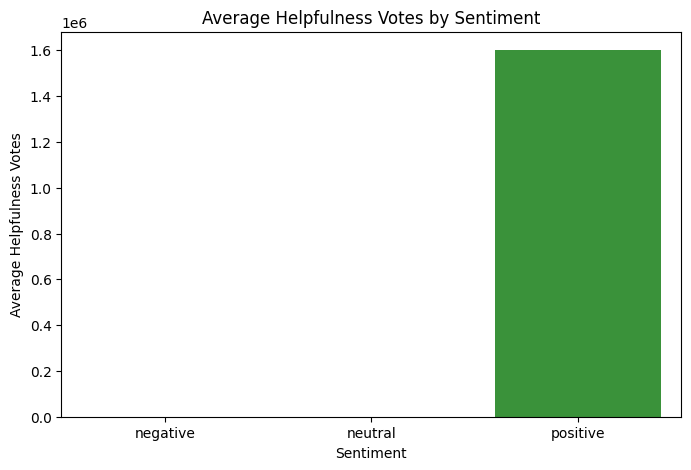

In [39]:
# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=mean_helpful_votes_non_zero.index, y=mean_helpful_votes_non_zero.values)
plt.title("Average Helpfulness Votes by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Helpfulness Votes")
plt.show()


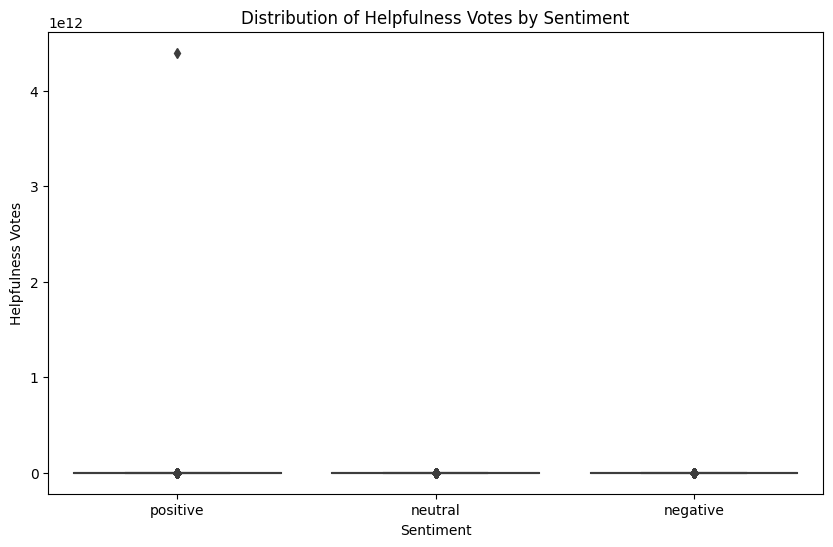

In [40]:
# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_reviews_helpfulness, x='sentiment', y='votes_helpful')
plt.title("Distribution of Helpfulness Votes by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Helpfulness Votes")
plt.show()
# It shows that positive contain an outlier that shift the axis and makes the plot useless

It shows that positive contain an outlier that shift the axis and makes the plot useless

In [41]:
# Map sentiment
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
final_reviews_helpfulness['sentiment_numeric'] = final_reviews_helpfulness['sentiment'].map(sentiment_mapping)

# Correlation
correlation = final_reviews_helpfulness['sentiment_numeric'].corr(final_reviews_helpfulness['votes_helpful'])
print("Correlation between Sentiment and Helpfulness Votes:", correlation)

Correlation between Sentiment and Helpfulness Votes: 0.00017204674132805626


sentiment has no meaningful impact on the number of helpfulness votes 

In [42]:
def identify_top_percent_outliers(df, column, percent=0.00001):
    outliers_df = pd.DataFrame()  
    outliers_count = {}       

    for sentiment in df['sentiment'].unique():
        subset = df[df['sentiment'] == sentiment]
        threshold = subset[column].quantile(1 - percent)

        # Identify outliers for this sentiment
        outliers_subset = subset[subset[column] > threshold]

        # Concatenate outliers to the outliers DataFrame
        outliers_df = pd.concat([outliers_df, outliers_subset])

        # Store the count of outliers identified for this sentiment
        outliers_count[sentiment] = len(outliers_subset)

    return outliers_df, outliers_count

outliers_identified, outliers_count = identify_top_percent_outliers(non_zero_reviews, 'votes_helpful')

print("\nNumber of Outliers Identified by Sentiment:")
print(outliers_count)

print("\nOutliers Identified (Votes Helpful) by Sentiment (Sorted from Greatest to Smallest):")
print(outliers_identified[['sentiment', 'votes_helpful']].sort_values(by='votes_helpful', ascending=False))


Number of Outliers Identified by Sentiment:
{'positive': 28, 'negative': 11, 'neutral': 8, nan: 0}

Outliers Identified (Votes Helpful) by Sentiment (Sorted from Greatest to Smallest):
         sentiment  votes_helpful
7698870   positive  4398046511106
4204335   positive          29608
5636123   positive          28211
14623929  negative          26149
10854995  positive          19927
13997772  positive          19707
10555982  negative          18030
12197247  positive          16993
5158693   positive          16960
13997771  negative          16090
13997593  positive          15776
10988208  negative          15598
14623972   neutral          15526
5632372    neutral          15385
9676152   negative          15160
5638898    neutral          15127
5636838   positive          14833
10760228  negative          14587
5098508    neutral          14408
14624422  negative          14349
6117451   positive          13625
9673029   negative          13595
5150527   negative          1349

In [43]:
def remove_single_greatest_outlier(df, column):
    # Identify the overall maximum value in votes_helpful
    max_value = df[column].max()
    
    # Find the row with the maximum votes_helpful value
    greatest_outlier = df[df[column] == max_value]
    
    # Remove the row with the greatest outlier from the DataFrame
    filtered_df = df[df[column] != max_value]
    
    return filtered_df, greatest_outlier

filtered_reviews, greatest_outlier = remove_single_greatest_outlier(non_zero_reviews, 'votes_helpful')

mean_helpful_votes_no_greatest_outlier = filtered_reviews.groupby('sentiment')['votes_helpful'].mean()
print("Mean Helpful Votes Among Reviews with at Least One Vote by Sentiment (Single Greatest Outlier Removed):")
print(mean_helpful_votes_no_greatest_outlier)

print("\nSingle Greatest Outlier Removed (Votes Helpful):")
outlier_reviews = greatest_outlier['review_id']
outlier_reviews

Mean Helpful Votes Among Reviews with at Least One Vote by Sentiment (Single Greatest Outlier Removed):
sentiment
negative   9.06
neutral    7.40
positive   6.77
Name: votes_helpful, dtype: float64

Single Greatest Outlier Removed (Votes Helpful):


7698870    63684360
Name: review_id, dtype: object

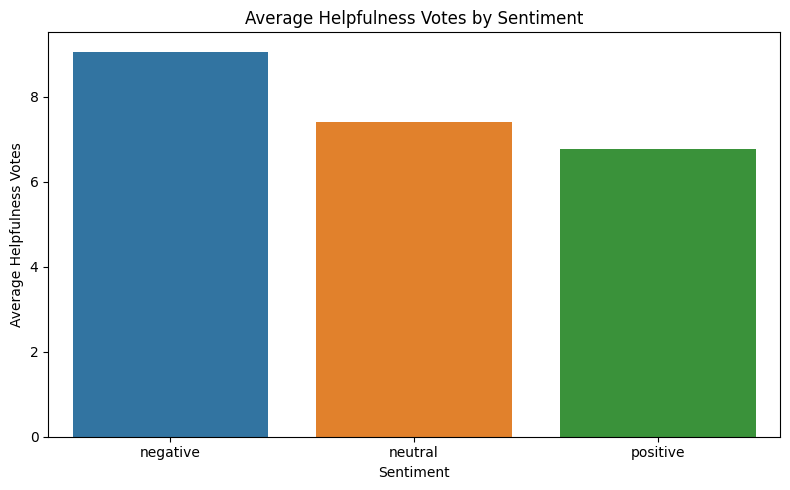

In [44]:
# Bar plot
average_helpfulness = filtered_reviews.groupby('sentiment')['votes_helpful'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='sentiment', y='votes_helpful', data=average_helpfulness)
plt.title("Average Helpfulness Votes by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Helpfulness Votes")
plt.tight_layout()
plt.show()



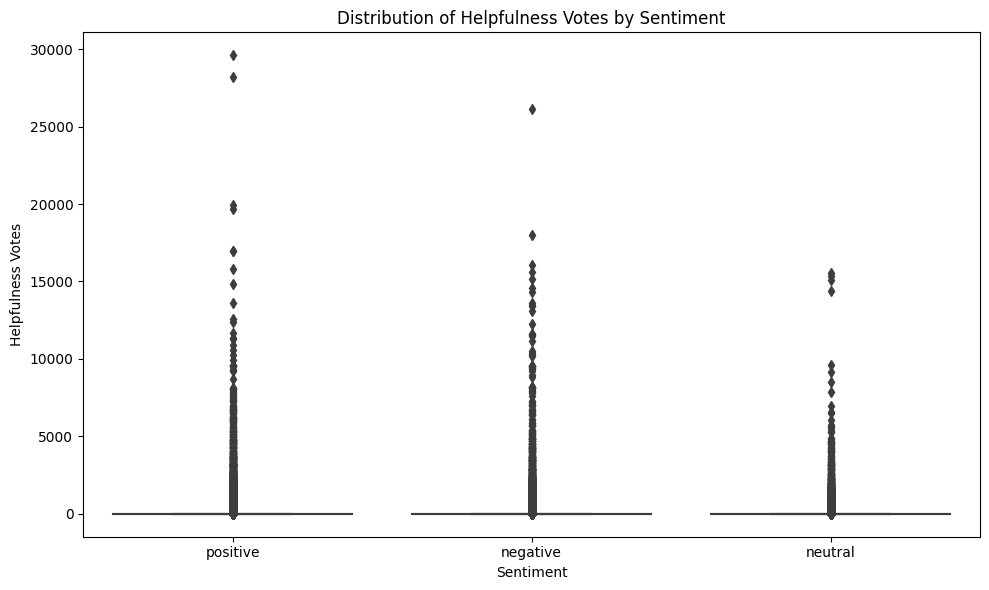

In [45]:
# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_reviews, x='sentiment', y='votes_helpful')
plt.title("Distribution of Helpfulness Votes by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Helpfulness Votes")
plt.tight_layout()
plt.show()

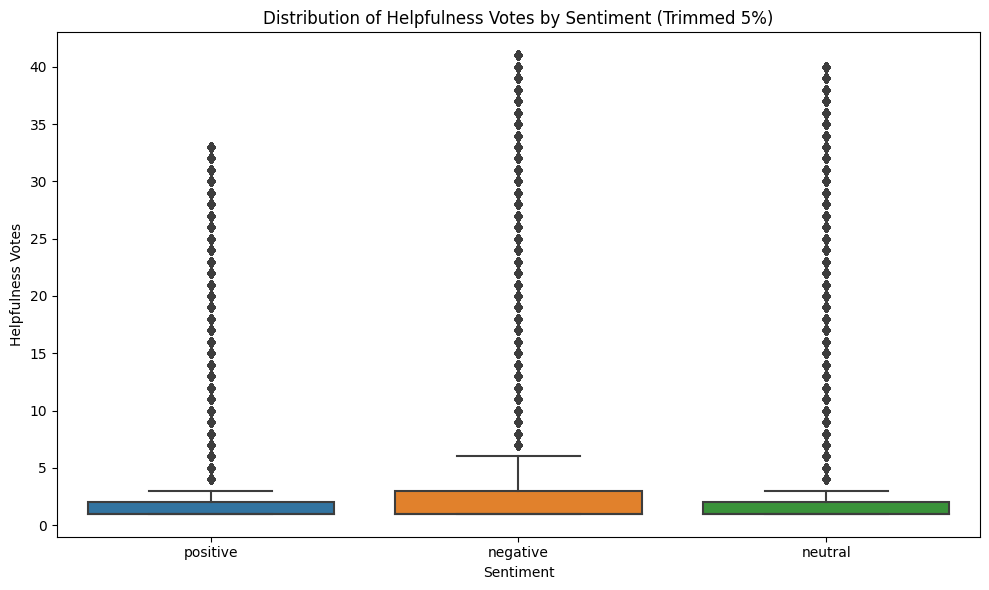

In [46]:
filtered_data = pd.DataFrame()
# Remove the tails (2.5%)
for sentiment in filtered_reviews['sentiment'].unique():
    sentiment_data = filtered_reviews[filtered_reviews['sentiment'] == sentiment]
    lower_bound = sentiment_data['votes_helpful'].quantile(0.025)
    upper_bound = sentiment_data['votes_helpful'].quantile(0.975)
    filtered_sentiment_data = sentiment_data[(sentiment_data['votes_helpful'] >= lower_bound) &
                                             (sentiment_data['votes_helpful'] <= upper_bound)]
    filtered_data = pd.concat([filtered_data, filtered_sentiment_data])

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='sentiment', y='votes_helpful')
plt.title("Distribution of Helpfulness Votes by Sentiment (Trimmed 5%)")
plt.xlabel("Sentiment")
plt.ylabel("Helpfulness Votes")
plt.tight_layout()
plt.show()


Negative reviews appear to have a slightly wider range and a higher median in helpfulness votes than positive or neutral reviews. This could imply that users are more likely to find critical (negative) reviews helpful.
